In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
df = pd.read_csv('Chinese_Names_120m.csv')

name = df.iloc[:5,0]

name = name.tolist()

name=''.join(name)

len(set(name))

set(name)

{'奥', '安', '昂', '爱', '艾', '阿'}

In [2]:
df = pd.read_csv('./data/names.csv')
data = ' '.join(df.name.tolist())

In [76]:
df

,name,gender,id
0,Emma,F,20799
1,Olivia,F,19674
2,Sophia,F,18490
3,Isabella,F,16950
4,Ava,F,15586
5,Mia,F,13442
6,Emily,F,12562
7,Abigail,F,11985
8,Madison,F,10247
9,Charlotte,F,10048


In [3]:
# data I/O
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 237097 characters, 53 unique.


In [61]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [62]:
hidden_size

100

In [63]:
vocab_size

53

In [64]:
# model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((vocab_size, 1)) # output bias

In [65]:
def lossFun(inputs, targets, hprev):
  """
  inputs,targets are both list of integers.
  hprev is Hx1 array of initial hidden state
  returns the loss, gradients on model parameters, and last hidden state
  """
  xs, hs, ys, ps = {}, {}, {}, {}
  hs[-1] = np.copy(hprev)
  loss = 0
  # forward pass
  for t in range(len(inputs)):
    xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][inputs[t]] = 1
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
    ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
    ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
    loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
  # backward pass: compute gradients going backwards
  dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
  dbh, dby = np.zeros_like(bh), np.zeros_like(by)
  dhnext = np.zeros_like(hs[0])
  for t in reversed(range(len(inputs))):
    dy = np.copy(ps[t])
    dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
    dWhy += np.dot(dy, hs[t].T)
    dby += dy
    dh = np.dot(Why.T, dy) + dhnext # backprop into h
    dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
    dbh += dhraw
    dWxh += np.dot(dhraw, xs[t].T)
    dWhh += np.dot(dhraw, hs[t-1].T)
    dhnext = np.dot(Whh.T, dhraw)
  for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
    #pass
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

In [66]:
def sample(h, seed_ix, n):
  """ 
  sample a sequence of integers from the model 
  h is memory state, seed_ix is seed letter for first time step
  """
  x = np.zeros((vocab_size, 1))
  x[seed_ix] = 1
  ixes = []
  for t in range(n):
    h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    y = np.dot(Why, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    ix = np.random.choice(range(vocab_size), p=p.ravel())
    x = np.zeros((vocab_size, 1))
    x[ix] = 1
    ixes.append(ix)
  return ixes

In [67]:
import time

In [68]:
import datetime as dt

In [69]:
print(dt.datetime.now())

2018-06-04 10:31:27.400814


In [70]:
learning_rate

0.1

In [71]:
all_losses = []

In [72]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
all
while True:
  # prepare inputs (we're sweeping from left to right in steps seq_length long)
  if p+seq_length+1 >= len(data) or n == 0: 
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    p = 0 # go from start of data
  inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
  targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

  # sample from the model now and then
  if n % 100 == 0:
    sample_ix = sample(hprev, inputs[0], 200)
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt, ))

  # forward seq_length characters through the net and fetch gradient
  loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001
  all_losses.append(loss)
  if n % 100 == 0:
        #print('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        print(f'iter {n}, loss: {loss}, smooth_loss: {smooth_loss} at {dt.datetime.now()}') # print progress
  
  # perform parameter update with Adagrad
  for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                [dWxh, dWhh, dWhy, dbh, dby], 
                                [mWxh, mWhh, mWhy, mbh, mby]):
    mem += dparam * dparam
    param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

  p += seq_length # move data pointer
  n += 1 # iteration counter 

----
 sGJEzpyrDMGWruPOzIwIxuETXNQqmctpdhEyQUsFayCqyUTbDZXEXjzzNXORNVHQEvcgTNGCZALfBIzZRO mIefIokpzWDnOvsgmpRIMcJnQaJkoCHVfZGWwbnZnVdgklsPFfLRjdU UfMUEShAlnmqgrbZJTIQBAeVoQbzqtfIYAIKyBvEMjYYGCzQNYGWUjbIOOeKo 
----
iter 0, loss: 99.25058789082718, smooth_loss: 99.25729112885507 at 2018-06-04 10:31:28.586814
----
 aiLeiLaiiial ida Lai  llh LanlairallaiLa rb iAeca Ha iaiiaSHa lanea ra ga ea  dieKeia ua razlald lia nerla  A radLa Kl rnSia i  raeMarCa ia mhRSBSi yLe raa a dr Aa  airaasaSchiLe aa ea MaiDa g GiinHe  
----
iter 100, loss: 93.84914513829233, smooth_loss: 99.16657034144252 at 2018-06-04 10:31:29.165814
----
 lerniyaCollya yaZ a rnealCnsCihit naainarCh ya BaeyanysnylSAehaa lniensJitaFv siKi Ae Aanam a iyniaL  n yiiynihaiamaenmYaer a ai slanhymCeei milca tiAliyhBeatAa Eeiyazaemsaadre e l rHyilaise amire yhu 
----
iter 200, loss: 72.33088874389797, smooth_loss: 97.27433277573034 at 2018-06-04 10:31:29.775814
----
 u hantKlloeKa DaMriiua Ki En lr an fnlla eiNDm iaeesllb tultls enyrMl

KeyboardInterrupt: 

In [74]:
np.mean(all_losses)

58.20381525104544

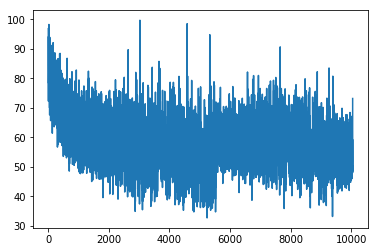

In [73]:
plt.plot(range(len(all_losses[50:])), all_losses[50:])

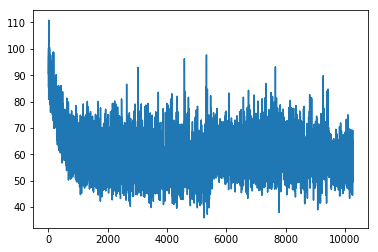

In [59]:
plt.plot(range(len(all_losses[50:])), all_losses[50:])

(array([49.,  0.,  2.,  2.,  1.,  0.,  1.,  1.,  0., 44.]),
 array([-9.99999999e-01, -8.00000000e-01, -6.00000001e-01, -4.00000001e-01,
        -2.00000002e-01, -2.61438959e-09,  1.99999997e-01,  3.99999996e-01,
         5.99999996e-01,  7.99999995e-01,  9.99999994e-01]),
 <a list of 10 Patch objects>)

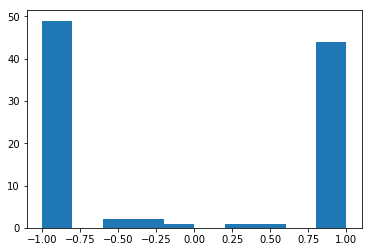

In [60]:
plt.hist(hprev)